# 01 – Preselect & Diagnostics (CAPE / CIN / Shear)
This notebook **does not run WRF**. It reads soundings from your Sobol experiment, computes diagnostics (CAPE, CIN, 0–1 km and 0–6 km bulk shear, PW), and visualizes **ranges and coverage**.

**Modes:**
1. *Generate mode*: Generate soundings on-the-fly using Sobol samples
2. *Folder mode*: Read existing WRF-ready `input_sounding_*` files from step2 output
3. *Diagnostics mode*: Load pre-computed diagnostics from step2

The goal is to explore **full distributions** – not just a low‑CAPE/high‑shear subset.

In [1]:
import numpy as np
import pickle
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from metpy.units import units
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')


# --- CONFIGURATION (Adjust Paths as needed) ---

REPO_ROOT = Path.cwd().parents[0] if (Path.cwd().name == 'notebooks') else Path.cwd()
SRC = REPO_ROOT / 'src'
sys.path.append(str(SRC))

try:
    from core.sounding_generator import (generate_sounding,
                                         read_input_sounding, 
                                         write_input_sounding,
                                         calculate_diagnostics)
except ImportError:
    print("ERROR: Could not import 'sounding_generator'.")
    print("Make sure 'sounding_generator.py' exists in the 'src/core/' directory.")
    sys.exit(1)

# For 'folder' mode: directory with input_sounding_* files
EXPERIMENT_DIR = str(REPO_ROOT / 'outputs' / 'sobol_exp_default')
BASE_SOUNDING = str(SRC / 'input_sounding')  # Your base sounding file
SOUNDINGS_DIR = str(REPO_ROOT / 'outputs' / 'sobol_exp_default' / 'soundings')

# For 'diagnostics' mode: path to diagnostics.pkl from step2
DIAGNOSTICS_FILE = str(REPO_ROOT / 'outputs' / 'sobol_exp_default' / 'soundings' / 'diagnostics.pkl')
VIABLE_SAMPLES_FILE = os.path.join(EXPERIMENT_DIR, 'soundings/viable_sample_ids.npy')
# --- LOAD DATA ---
try:
    # Load parameter metadata (for names) and all parameters
    with open(os.path.join(EXPERIMENT_DIR, 'problem.pkl'), 'rb') as f:
        problem = pickle.load(f)
    param_values = np.load(os.path.join(EXPERIMENT_DIR, 'param_values.npy'))
    
    # Load all MetPy diagnostic data (for filtering check)
    with open(DIAGNOSTICS_FILE, 'rb') as f:
        diagnostics = pickle.load(f)
        
    # Load the indices of the soundings that passed the filter (424 indices)
    viable_indices = np.load(VIABLE_SAMPLES_FILE)
    print(f"Loaded {len(viable_indices)} viable sample indices.")
    
except FileNotFoundError as e:
    print(f"Error: Missing experiment file. Ensure steps 1, 2, and 2b were run. \nDetails: {e}")
    # Handle error or exit
#viable_indices = np.ones_like(param_values[:,0], dtype=bool)
# --- Filter diagnostics to viable samples only ---
# Create an index mask if your diagnostics.pkl is a flat list
# This assumes the 'sample_id' array in diagnostics tracks the original index
viable_mask = np.isin(diagnostics['sample_id'], viable_indices)

# Extract MUCAPE statistics for the final plot title/summary
viable_mucape = np.array(diagnostics['mucape'])[viable_mask]
print(f"Viable MUCAPE Range: Min={np.min(viable_mucape):.0f} J/kg, Max={np.max(viable_mucape):.0f} J/kg")

Loaded 5480 viable sample indices.
Viable MUCAPE Range: Min=13 J/kg, Max=8241 J/kg


In [2]:
# --- Build diagnostics catalog ---
rows = []
print(f"Loading pre-computed diagnostics from {DIAGNOSTICS_FILE}...")
with open(DIAGNOSTICS_FILE, 'rb') as f:
    diag_dict = pickle.load(f)

# Convert to format expected by notebook
for i in range(len(diag_dict['sample_id'])):
    if np.isin(i, viable_indices):
        rows.append({
            'idx': diag_dict['sample_id'][i],
            'MUCAPE': diag_dict['mucape'][i],
            'MUCIN': diag_dict['mucin'][i],
            'SH01': diag_dict['shear_0_1km'][i],
            'SH03': diag_dict['shear_0_3km'][i],
            'SH06': diag_dict['shear_0_6km'][i],
            'PW': diag_dict['pwat'][i]
        })

df = pd.DataFrame(rows)
df.describe(include='all')

Loading pre-computed diagnostics from /nfsmounts/storage/scratch/jorge.gacitua/Supercell_WRF_Sensitivity/outputs/sobol_exp_default/soundings/diagnostics.pkl...


,idx,MUCAPE,MUCIN,SH01,SH03,SH06,PW
count,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000
mean,2746.354197,2547.114999,-5.002794,1.649190,4.689764,8.073725,38.885567
std,1587.525990,1649.745312,6.340837,0.476873,1.391942,2.899671,7.538943
min,0.000000,13.437001,-44.901893,0.813914,1.863964,1.908068,24.037364
25%,1370.750000,1201.845481,-7.789671,1.238139,3.518127,5.792606,32.671488
50%,2742.500000,2328.367030,-2.772959,1.646865,4.653800,7.700663,38.184004
75%,4120.250000,3590.854329,0.000000,2.063791,5.845723,10.372871,44.573598
max,5499.000000,8240.737425,0.000000,2.489862,7.470302,14.954047,62.447167


## Distributions – CAPE, |CIN|, and Shear
These give you the **ranges** covered by your design. CIN is plotted as absolute value.

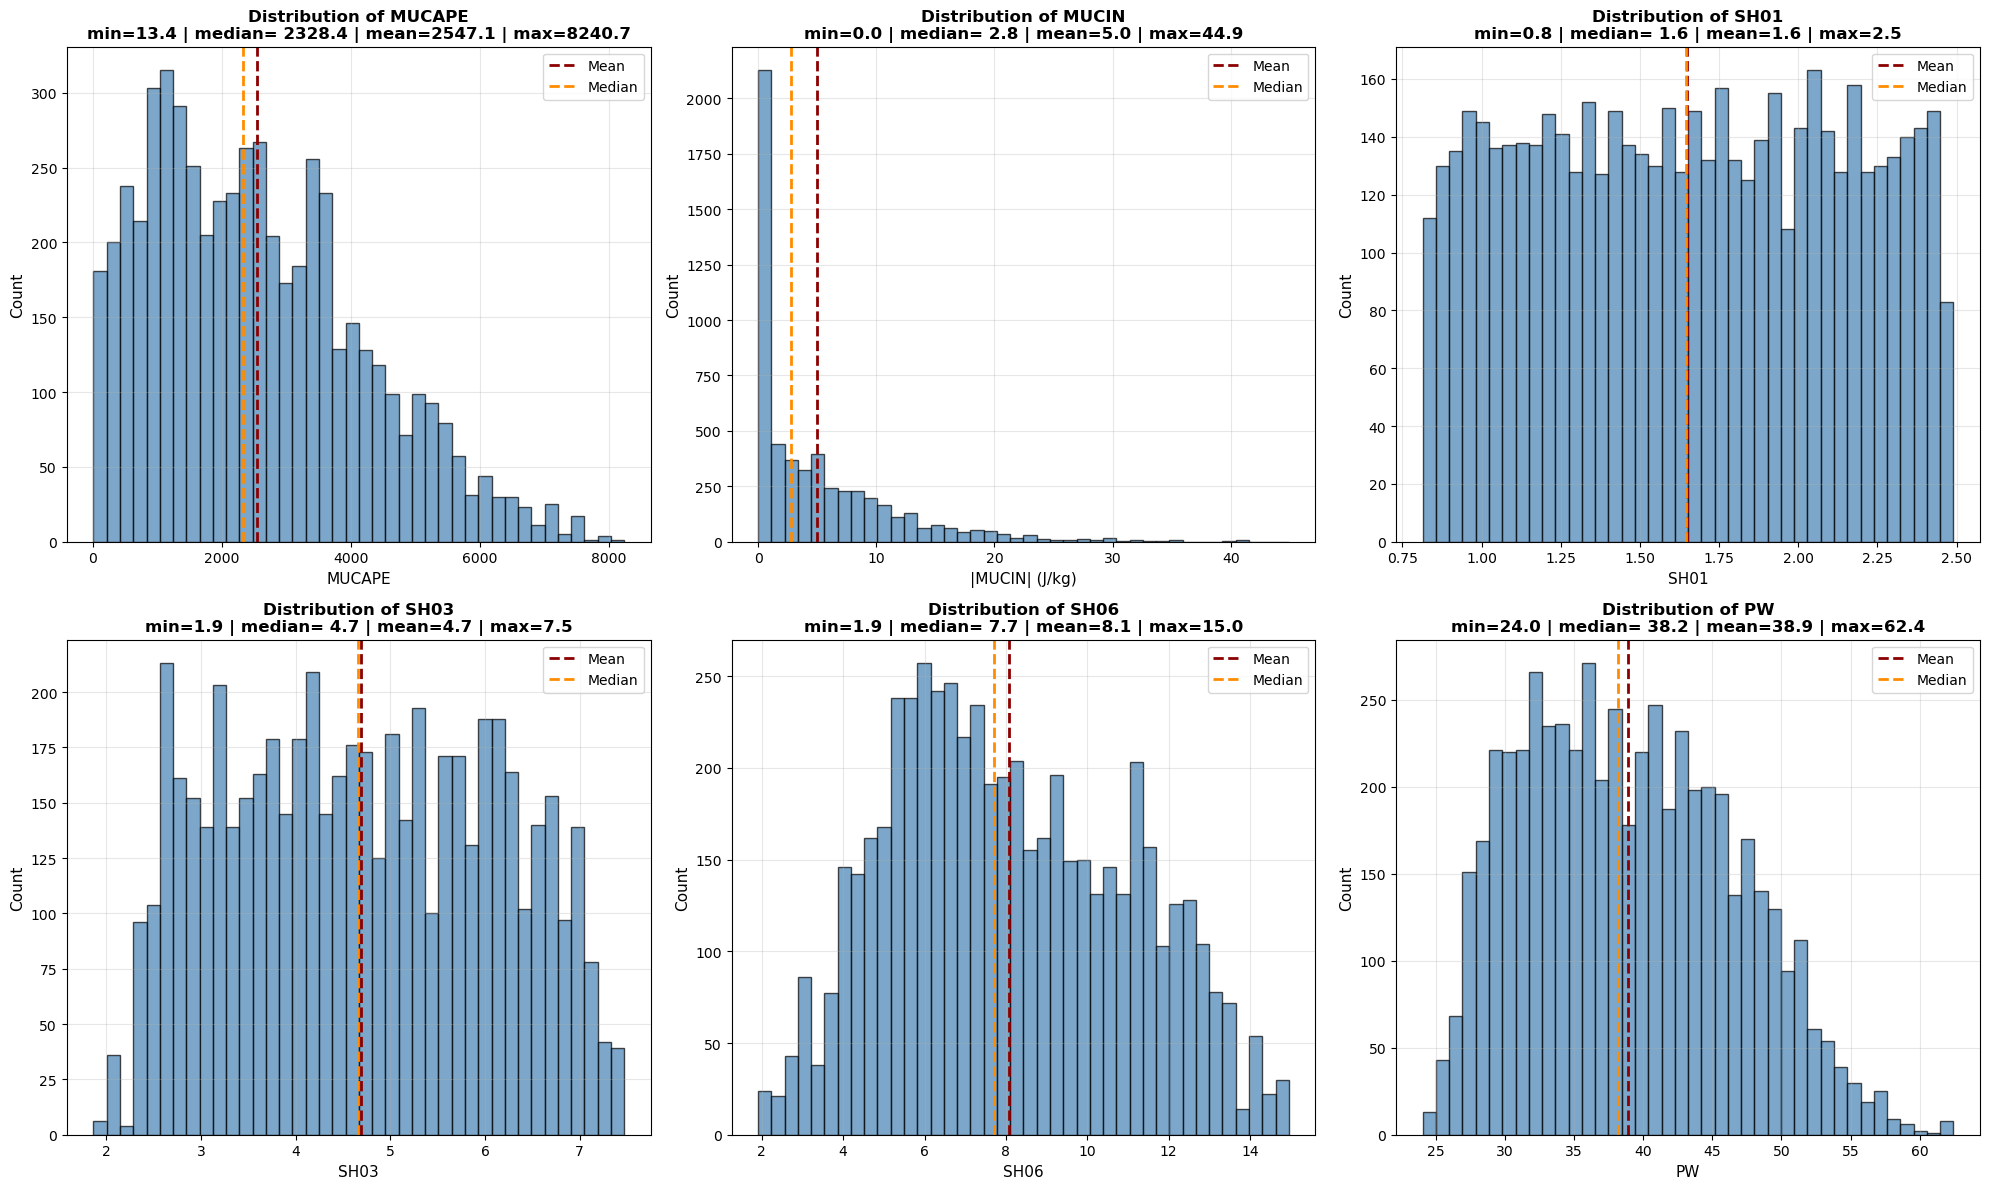

In [3]:

fig, axs = plt.subplots(2,3,figsize=(20, 12))
axs=axs.flatten()
for i,col in enumerate(['MUCAPE','MUCIN','SH01','SH03','SH06','PW']):
    ax = axs[i]
    if col not in df.columns: 
        continue
    vals = np.abs(df[col]) if col=='MUCIN' else df[col]
    vals_clean = vals.dropna()
    
    if len(vals_clean) == 0:
        print(f"No valid data for {col}")
        continue

    ax.hist(vals_clean.values, bins=40,facecolor='SteelBlue', edgecolor='black', alpha=0.7)
    ax.set_xlabel(col if col!='MUCIN' else '|MUCIN| (J/kg)', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)

    ax.grid(alpha=0.3)
    
    # Add statistics
    mean_val = vals_clean.mean()
    median_val = vals_clean.median()
    ax.axvline(mean_val, color='DarkRed', linestyle='--', linewidth=2, label=f'Mean')
    ax.axvline(median_val, color='DarkOrange', linestyle='--', linewidth=2, label=f'Median')
    ax.legend()
    ax.set_title(f'Distribution of {col}\n'+
              f'min={vals_clean.min():.1f} | median= {median_val:.1f} | mean={mean_val:.1f} | max={vals_clean.max():.1f}'
              , fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 2‑D Coverage (hexbin)
Quick maps to see where samples land: **CAPE vs shear**, and **CAPE vs |CIN|**.

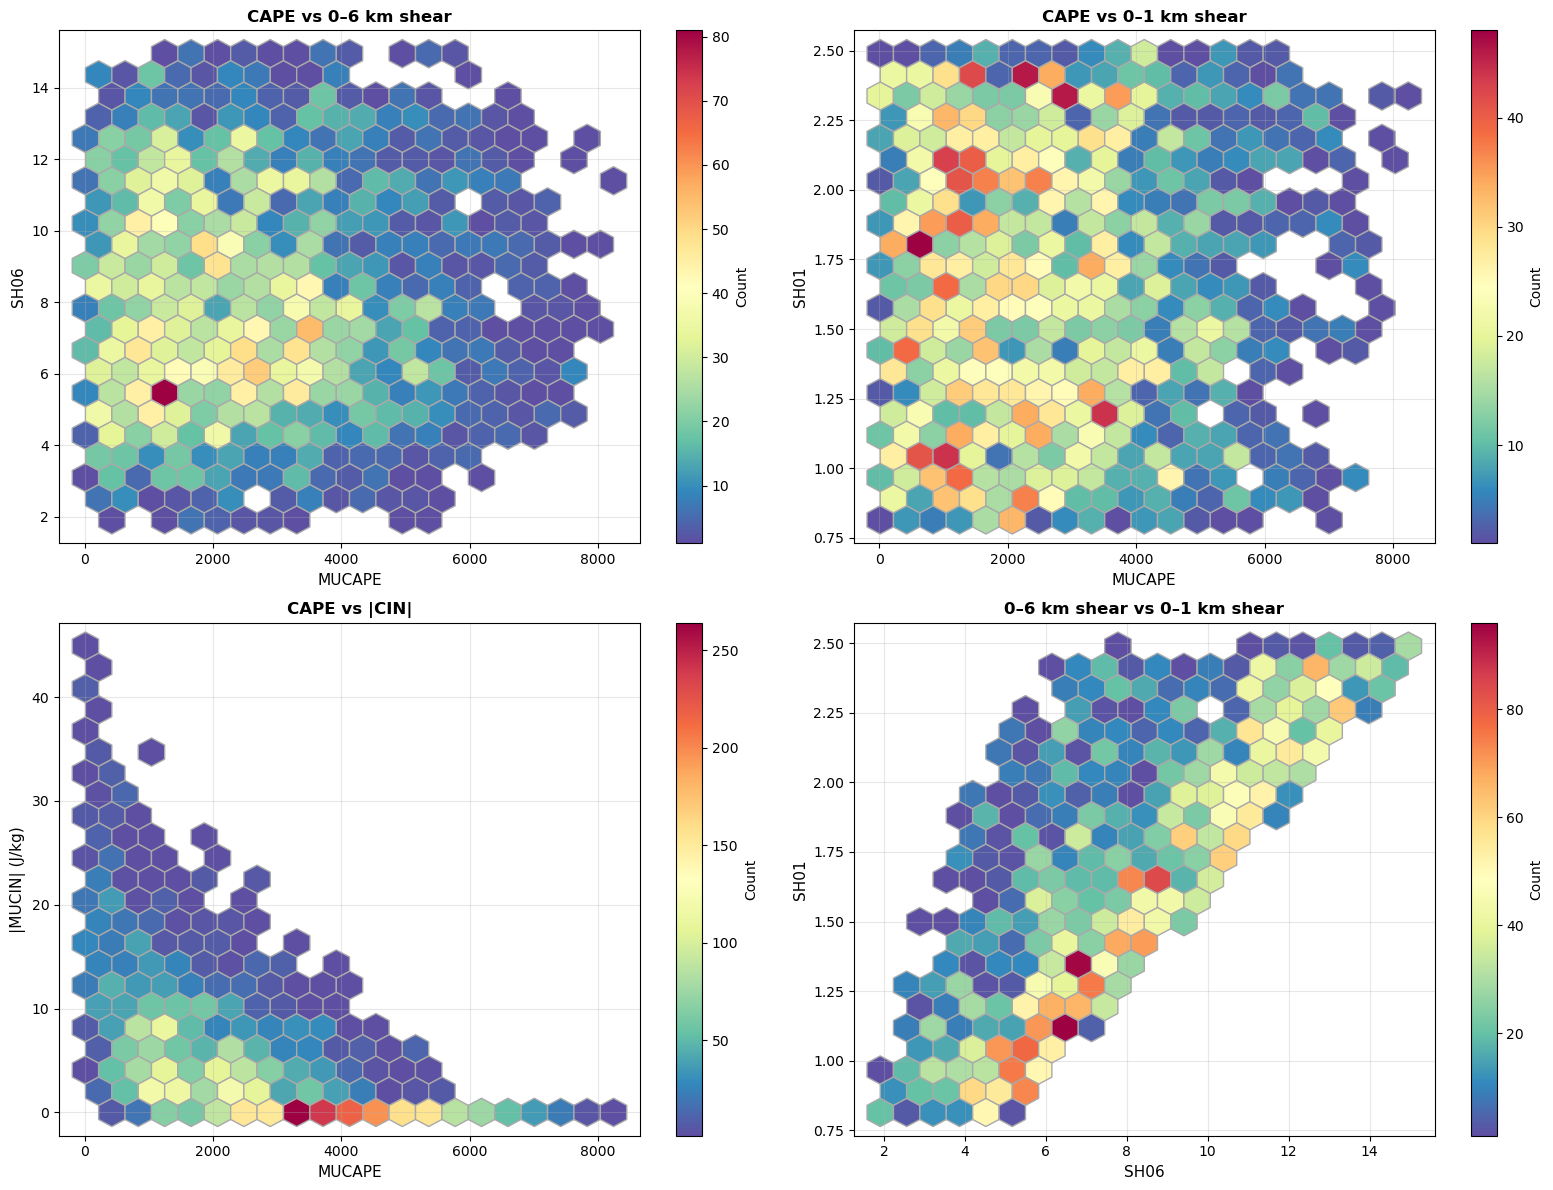

In [4]:
pairs = [
    ('MUCAPE','SH06','CAPE vs 0–6 km shear'),
    ('MUCAPE','SH01','CAPE vs 0–1 km shear'),
    ('MUCAPE','MUCIN','CAPE vs |CIN|'),
    ('SH06','SH01','0–6 km shear vs 0–1 km shear'),
]

fig, axs = plt.subplots(2,2,figsize=(16, 12))
axs=axs.flatten()
for i, (x, y, title) in enumerate(pairs):
    if x not in df or y not in df: 
        continue
    
    xv = df[x].values
    yv = np.abs(df[y].values) if y=='MUCIN' else df[y].values
    
    # Remove NaN
    mask = ~(np.isnan(xv) | np.isnan(yv))
    xv = xv[mask]
    yv = yv[mask]
    
    if len(xv) == 0:
        print(f"No valid data for {title}")
        continue
    
    ax = axs[i]
    hb = ax.hexbin(xv, yv, gridsize=20, mincnt=1, cmap='Spectral_r',edgecolors='Darkgrey')
    ax.set_xlabel(x if x!='MUCIN' else '|MUCIN| (J/kg)', fontsize=11)
    ax.set_ylabel(y if y!='MUCIN' else '|MUCIN| (J/kg)', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    cb = plt.colorbar(hb, label='Count')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3D Scatter: CAPE vs Shear vs |CIN|
Visualize the full 3D parameter space coverage.

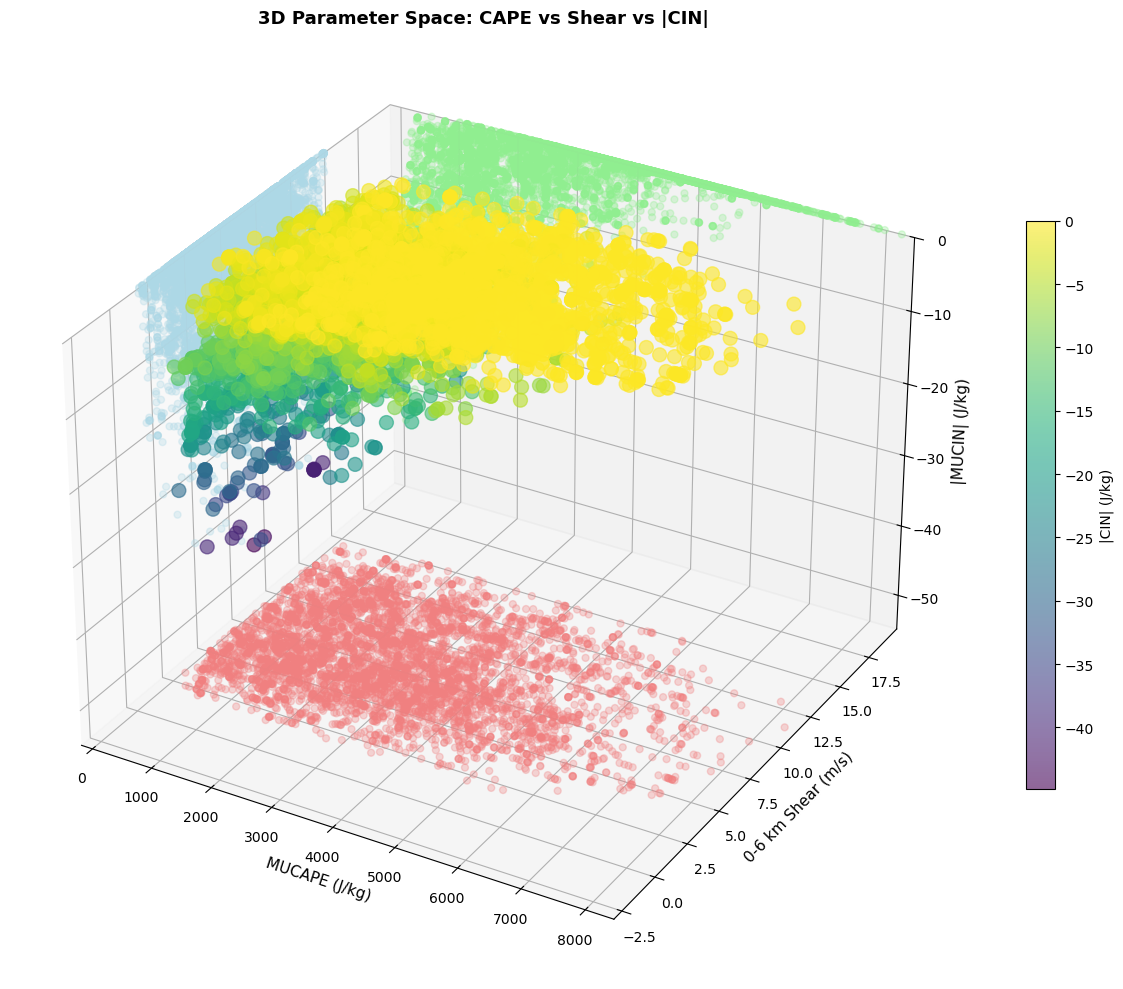

In [5]:
from mpl_toolkits.mplot3d import Axes3D

# Clean data
mask = df['MUCAPE'].notna() & df['SH06'].notna() & df['MUCIN'].notna()
df_clean = df[mask].copy()
#print(df_clean)
if len(df_clean) > 0:
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Main 3D scatter
    scatter = ax.scatter(
        df_clean['MUCAPE'], 
        df_clean['SH06'], 
        df_clean['MUCIN'],
        c=df_clean['MUCIN'], 
        cmap='viridis',
        marker='o', 
        s=100, 
        alpha=0.6
    )
    
    ax.set_xlabel('MUCAPE (J/kg)', fontsize=11)
    ax.set_ylabel('0-6 km Shear (m/s)', fontsize=11)
    ax.set_zlabel('|MUCIN| (J/kg)', fontsize=11)
    ax.set_title('3D Parameter Space: CAPE vs Shear vs |CIN|', fontsize=13, fontweight='bold')
    
    # Set reasonable axis limits
    ax.set_xlim(df_clean['MUCAPE'].min() - 200, df_clean['MUCAPE'].max() + 200)
    ax.set_ylim(df_clean['SH06'].min() - 5, df_clean['SH06'].max() + 5)
    ax.set_zlim(df_clean['MUCIN'].min()-10, 0)
    
    # Projections on walls
    ax.scatter(
        df_clean['MUCAPE'], 
        df_clean['SH06'], 
        zs=df_clean['MUCIN'].min()-10, 
        zdir='z', 
        c='lightcoral', 
        marker='.', 
        s=100, 
        alpha=0.3
    )
    ax.scatter(
        df_clean['MUCAPE'], 
        zs=df_clean['SH06'].max() + 5, 
        zdir='y', 
        ys=df_clean['MUCIN'], 
        c='lightgreen', 
        marker='.', 
        s=100, 
        alpha=0.3
    )
    ax.scatter(
        zs=df_clean['MUCAPE'].min() - 200, 
        zdir='x', 
        xs=df_clean['SH06'], 
        ys=df_clean['MUCIN'], 
        c='lightblue', 
        marker='.', 
        s=100, 
        alpha=0.3
    )
    
    plt.colorbar(scatter, label='|CIN| (J/kg)', shrink=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No valid data for 3D plot")